In [26]:
import os
import sys
import time
import numpy as np
import cv2
from glob import glob
from pathlib import Path

from utils.homography import compute_h, cor_p
from utils.triangulation import triangulation
from pathlib import Path
from shapely.geometry import Polygon
from matplotlib import pyplot as plt

In [27]:
def kmeans(im, numWords=7):
    r, c = im.shape[:-1]
    step = 4

    rgbs = []
    for x in range(0, c, step):
        for y in range(0, r, step):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    _, _, vocab = cv2.kmeans(rgbs, numWords, None, criteria, attempts, flags)
    print('kmeans time: {:6}s'.format(time.time() - start_time))

    vocab_col = [[max(0, min(255, c)) for c in word] for word in vocab]
    return vocab, vocab_col

def clustering(im):
    start_time = time.time()
    r, c = im.shape[:-1]
    vocab, vocab_col = kmeans(im)

    bf = cv2.BFMatcher()
    rgbs = []
    for x in range(c):
        for y in range(r):
            rgbs.append(im[y][x].tolist())
    rgbs = np.array(rgbs, dtype=np.float32)
    matches = bf.knnMatch(rgbs, vocab, k=1)

    out = np.array([[vocab_col[matches[x * r + y][0].trainIdx] for x in range(c)] for y in range(r)], dtype=np.uint8)
    print('Clustering time: {:6}s'.format(time.time() - start_time))
    return out

kmeans time: 0.8780267238616943s
Clustering time: 6.564795970916748s
kmeans time: 0.5690951347351074s
Clustering time: 6.2960755825042725s
kmeans time: 0.9204010963439941s
Clustering time: 7.301969528198242s
kmeans time: 1.6130521297454834s
Clustering time: 8.435575246810913s


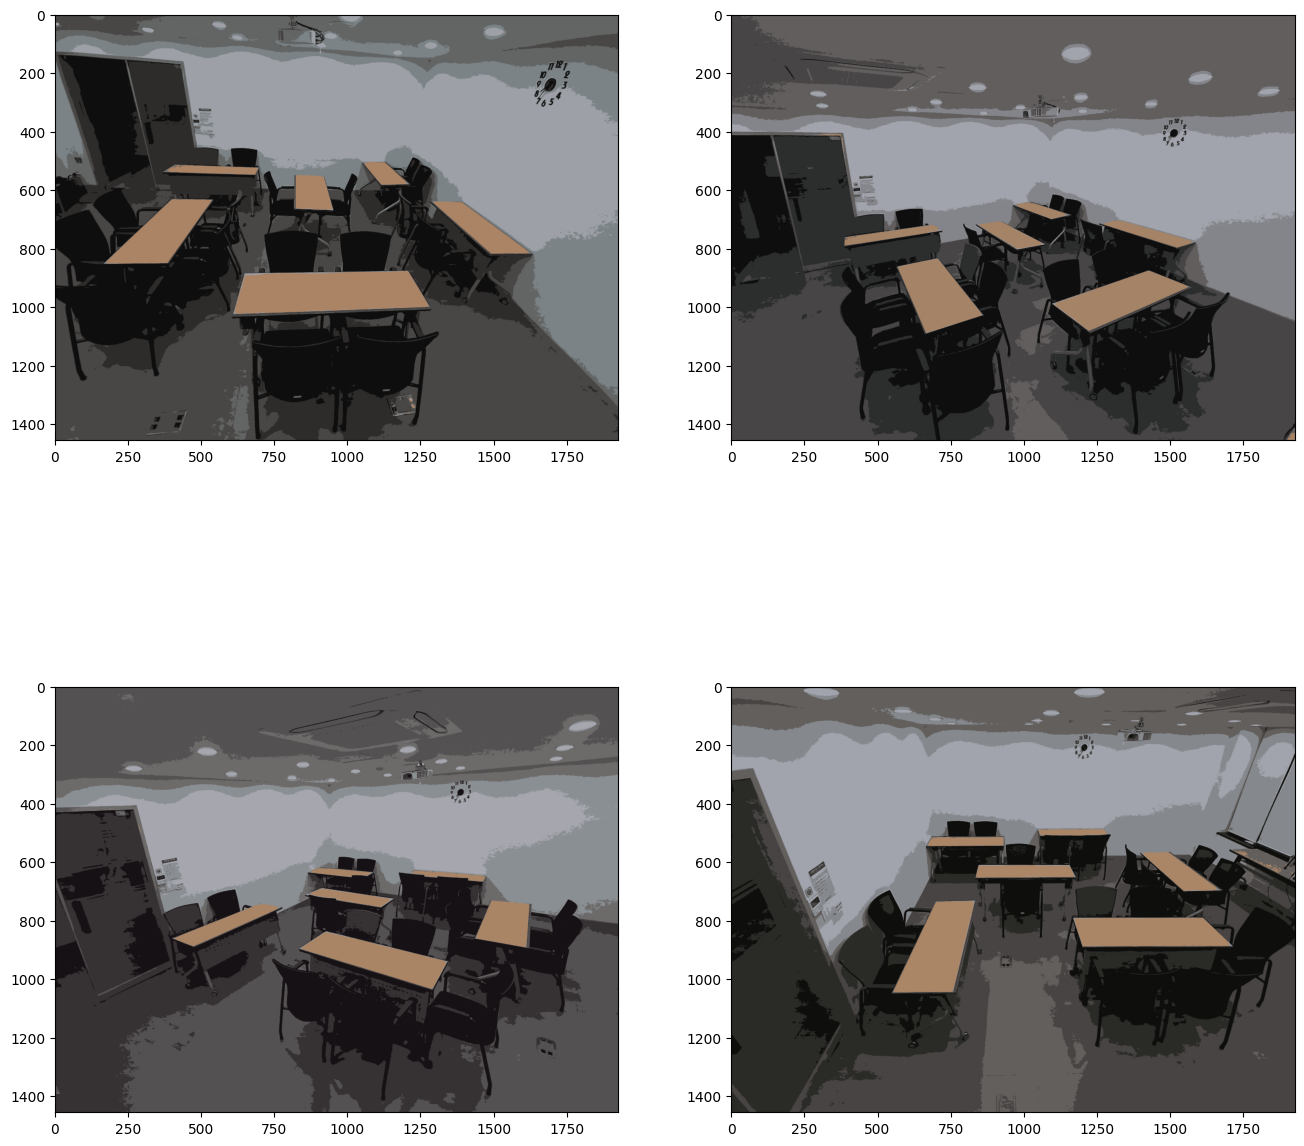

In [30]:
plt.figure(figsize=(16, 16))
for id in range(4):
    p = f"data/layout/cam{id}/00000.jpg"
    im = cv2.imread(p)
    out = clustering(im)
    save_dir = Path(f'data/layout_clustered/cam{id}')
    save_dir.mkdir(parents=True, exist_ok=True)  # make dir
    cv2.imwrite(f"data/layout_clustered/cam{id}/00000.jpg", out)
    plt.subplot(2, 2, id+1)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
